### Ch7: Extract features from MRI prostrate images and plot t-SNE plots

In [1]:
import time
start_time=time.time()
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(device)

cuda


Using device: cuda


Using cache found in /home/jupyter/.cache/torch/hub/facebookresearch_dino_main
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


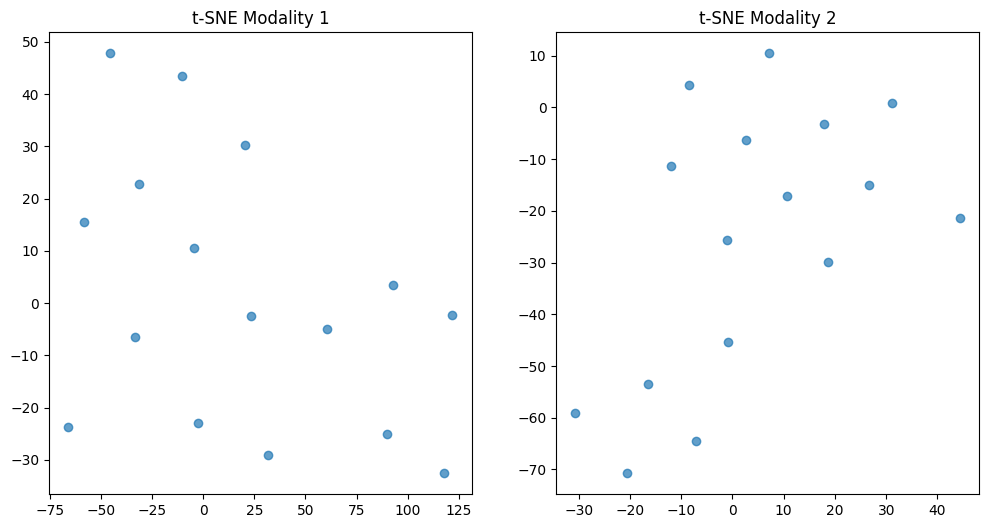

In [3]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms
from sklearn.manifold import TSNE

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the DINO ResNet-50 model
resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
resnet50.to(device)
resnet50.eval()

# Directory containing the .nii.gz files
image_dir = "bucket/Med Decathlon Prostate/151/artifactFiles/imagesTs"

# Function to extract features from a 2D slice
def extract_features(slice_2d):
    # Stack the 2D slice into three identical channels
    slice_3d = np.stack([slice_2d] * 3, axis=-1)
    
    # Normalize the slice to the range [0, 255] and convert to uint8
    min_val = np.min(slice_3d)
    max_val = np.max(slice_3d)
    if max_val > min_val:
        slice_3d = (slice_3d - min_val) / (max_val - min_val) * 255
    else:
        slice_3d = np.zeros_like(slice_3d)  # Set to zero if min and max are the same
    slice_3d = slice_3d.astype(np.uint8)
    
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(slice_3d)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        features = resnet50(input_batch)
    return features.cpu().numpy()

# Iterate over each file in the directory
features_modality_1 = []
features_modality_2 = []

for filename in os.listdir(image_dir):
    if filename.endswith(".nii.gz"):
        # Load the image
        image = sitk.ReadImage(os.path.join(image_dir, filename))
        image_array = sitk.GetArrayFromImage(image)

        # Extract and average features for each slice in the first modality (index 0)
        file_features_modality_1 = []
        for slice_idx in range(image_array.shape[2]):
            slice_2d = image_array[:, :, slice_idx, 0]
            features = extract_features(slice_2d)
            file_features_modality_1.append(features)
        # Average over the channel dimension
        avg_features_modality_1 = np.mean(file_features_modality_1, axis=0)
        features_modality_1.append(avg_features_modality_1.flatten())
  
        # Extract and average features for each slice in the second modality (index 1)
        file_features_modality_2 = []
        for slice_idx in range(image_array.shape[2]):
            slice_2d = image_array[:, :, slice_idx, 1]
            features = extract_features(slice_2d)
            file_features_modality_2.append(features)
        # Average over the channel dimension
        avg_features_modality_2 = np.mean(file_features_modality_2, axis=0)
        features_modality_2.append(avg_features_modality_2.flatten())
        

# Convert lists to numpy arrays
features_modality_1 = np.array(features_modality_1)
features_modality_2 = np.array(features_modality_2)

# Apply t-SNE
tsne_modality_1 = TSNE(n_components=2, perplexity=10, random_state=42).fit_transform(features_modality_1)
tsne_modality_2 = TSNE(n_components=2, perplexity=10, random_state=42).fit_transform(features_modality_2)

# Visualize the t-SNE plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("t-SNE Modality 1")
plt.scatter(tsne_modality_1[:, 0], tsne_modality_1[:, 1], alpha=0.7)

plt.subplot(1, 2, 2)
plt.title("t-SNE Modality 2")
plt.scatter(tsne_modality_2[:, 0], tsne_modality_2[:, 1], alpha=0.7)

plt.show()

In [4]:
end_time=time.time()
total_time=end_time-start_time
print("total time :",total_time)

total time : 172.17191410064697
